# Deep Learning Project - Orca Call Clustering 
Karlee Zammit - V00823093 

https://github.com/earthspecies/library/tree/main/orcas

https://debuggercafe.com/pytorch-pretrained-efficientnet-model-image-classification/

In [18]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchvision.datasets import ImageFolder
from PIL import Image, ImageOps
import os.path, sys
import tensorflow as tf
import torchaudio
import torchaudio.transforms as T
import librosa
import matplotlib.pyplot as plt
import wave
from IPython.display import Audio
from torchvision.io import read_image
import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from sklearn.model_selection import train_test_split
!pip install torch torchvision efficientnet_pytorch==0.7.0
from efficientnet_pytorch import EfficientNet

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Functions

In [19]:
# Plot and save the waveform from the wave file 
def plot_waveform(idx, waveform, sr, title="Waveform"):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    figure, axes = plt.subplots(num_channels, 1)
    axes.plot(time_axis, waveform[0], linewidth=1)
    axes.grid(True)
    figure.suptitle(title)
    plt.show(block=False)
    #plt.savefig(r'C:\Users\kzammit\Repos\school\phys555\project-DL\orcas_classification\wavpngs\wav-' + str(idx) + '.png')
    plt.close()

In [20]:
# Plot and save the spectrogram from the wave file
#def create_spectrogram(idx, specgram, title=None, ylabel="freq_bin"):
def create_spectrogram(idx, specgram):
    #fig, axs = plt.subplots(1, 1)
    #axs.set_title(title or "Spectrogram (db)")
    #axs.set_ylabel(ylabel)
    #axs.set_xlabel("frame")
    #axs.set_ylim(0, 100)
    #print(specgram.shape)
    #imgf = np.flip(specgram, axis=0)
    transform=transforms.ToPILImage()
    #specgram=transform(specgram)
    specgram= transform(specgram)
    specgram = ImageOps.flip(specgram)
    #specgram.save(r"C:\Users\kzammit\Documents\PHYS555\orcas_classification\specs\spec-" + str(idx) + ".png")
    display(specgram)
    
    #im = Image.fromarray(librosa.power_to_db(specgram))
    #if im.mode != 'RGB':
    #    im = im.convert('RGB')
    #im.save("your_file.jpeg")
    #im = axs.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto")
    # librosa... is a numpy array, save that to a png file instead 
    #fig.colorbar(im, ax=axs)
    #plt.show(block=False)
    #plt.savefig(r'C:\Users\kzammit\Repos\school\phys555\project-DL\orcas_classification\spectrograms\spec-' + str(idx) + '.png')
    #plt.close()

In [21]:
# Crop the spectrogram figures and save as pngs
def crop(path, dirs):
    for item in dirs:
        fullpath = os.path.join(path,item)
        if os.path.isfile(fullpath):
            im = Image.open(fullpath)
            f, e = os.path.splitext(fullpath)
            # last one does the height
            # left top right bottom
            imCrop = im.crop((80, 58, 475, 425)) #corrected
            #imCrop.save(f + '-crop.png', "PNG", quality=300)
            display(imCrop)

In [22]:
def preprocess():
    
    transform =  transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor()])
        
        #transforms.Normalize(mean=[0.485], 
        #                     std=[0.229]),])
    return transform

# Spectrogram Generation and Preprocessing

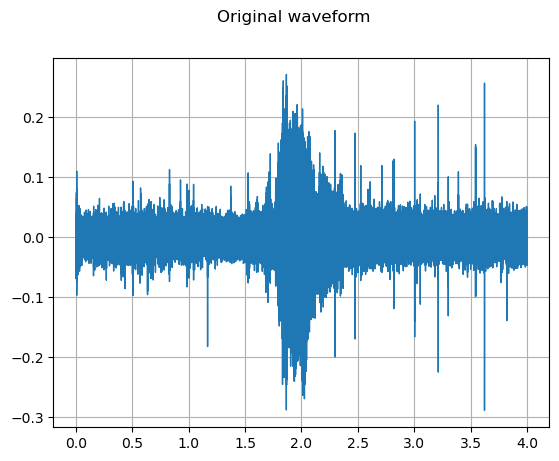

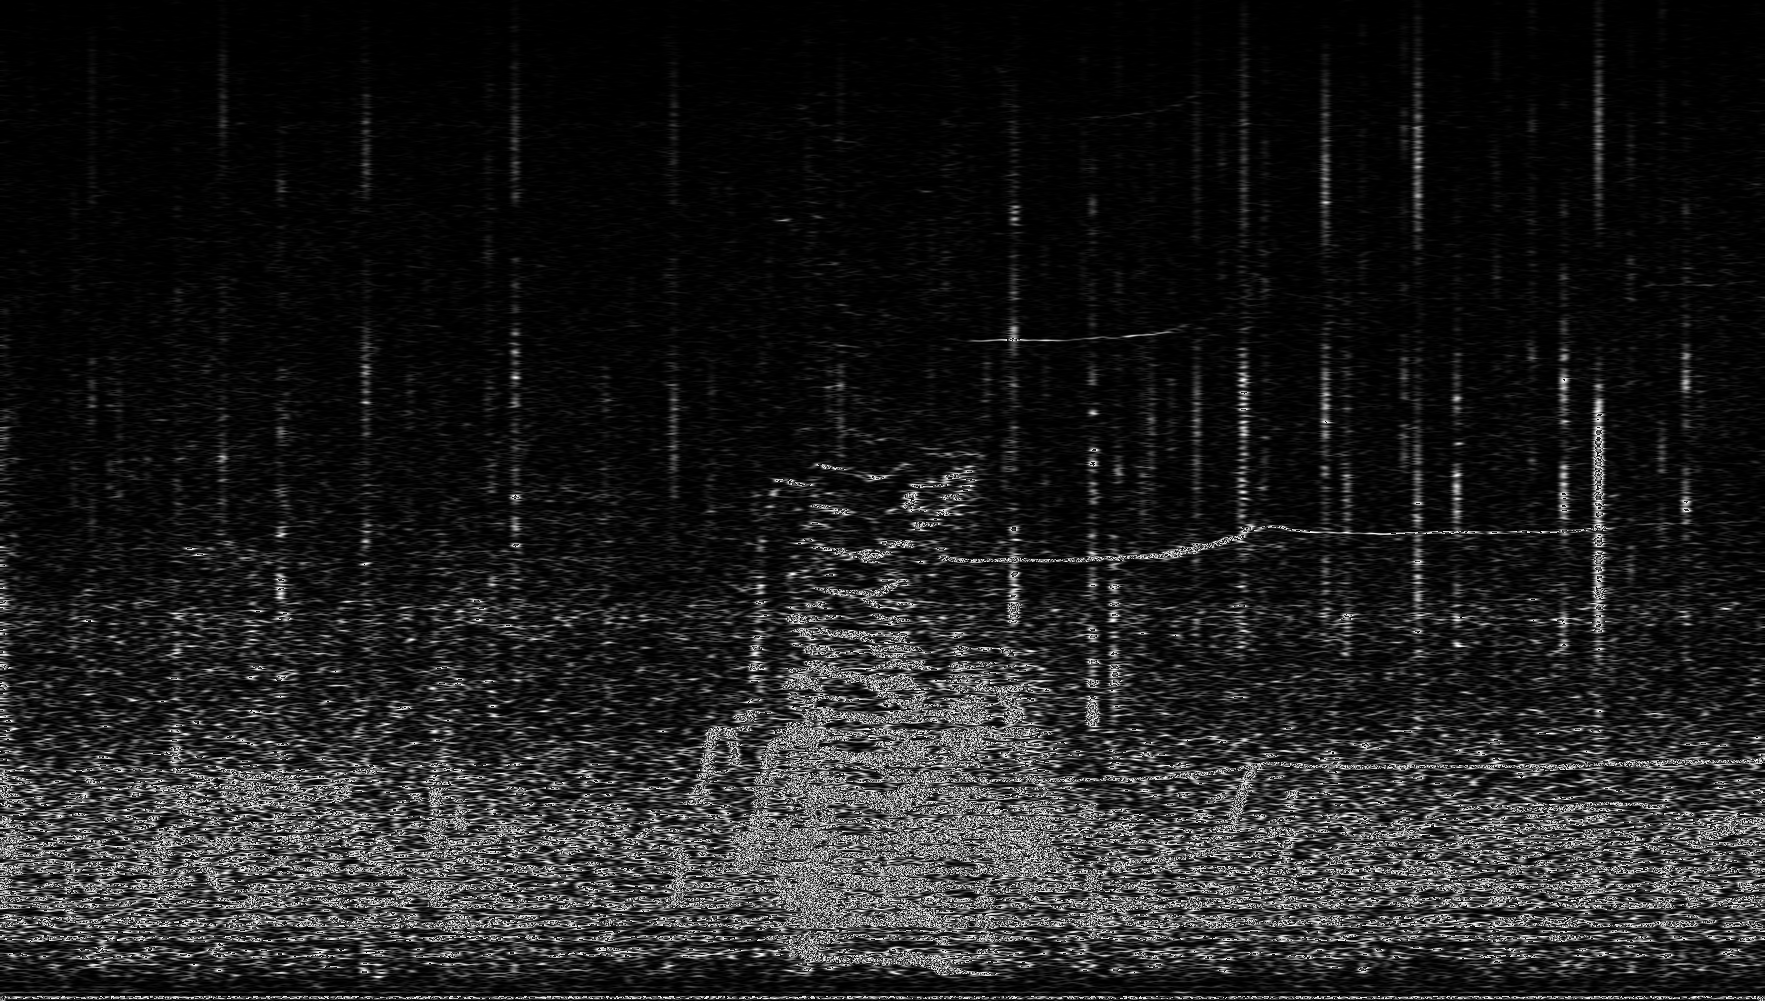

In [57]:
# For each available wave file
for ii in range(59, 60):
    
    # In the audio folder 
    path = r'C:\Users\kzammit\Documents\PHYS555\orcas_classification\audio'
    
    # Get the file name and path
    file = '\\' + str(ii) + '.wav'
    fullfile = path + file

    # Set the sample to this file
    SAMPLE_WAV = fullfile

    # Load the wave with torchaudio 
    ORCA_WAVEFORM, SAMPLE_RATE = torchaudio.load(SAMPLE_WAV)

    # Plot the original waveform 
    plot_waveform(idx=str(ii), waveform=ORCA_WAVEFORM, sr=SAMPLE_RATE, title="Original waveform")
    Audio(ORCA_WAVEFORM.numpy(), rate=SAMPLE_RATE)

    # Set the spectrogram parameters 
    n_fft = 2000
    win_length = 2000
    hop_length = 100

    # Define spectrogram settings using torch audio transforms  
    spectrogram = T.Spectrogram(n_fft=n_fft, win_length=win_length, hop_length=hop_length, center=True, pad_mode="reflect", power=2.0)
    
    # Calculate the spectrogram 
    spec = spectrogram(ORCA_WAVEFORM)
    
    # Plot and save the spectrogram
    create_spectrogram(idx=str(ii), specgram=spec[0])

# Load in ORCA Data

In [23]:
class OrcaImageDataset(Dataset):
    
    def __init__(self, annotations_file, img_dir, transform, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [24]:
annotations_file = r"C:\Users\kzammit\Documents\PHYS555\orcas_classification\annotations-edited.csv"
img_dir = r"C:\Users\kzammit\Documents\PHYS555\orcas_classification\specs"
transforms_eff = preprocess()
orca_dataset = OrcaImageDataset(annotations_file, img_dir, transform=transforms_eff)
labels = orca_dataset.img_labels

In [25]:
xtrain_data, test_data, ytrain_labels, test_labels = train_test_split(
    orca_dataset, labels, test_size=0.2, random_state=21)

#  split a validation set from the training set
train_data, val_data, train_labels, val_labels = train_test_split(
    xtrain_data, ytrain_labels, test_size=0.2, random_state=22)

In [26]:
print('The number of samples for training is ' + str(len(train_data)))
print('The number of samples for validation is ' + str(len(val_data)))
print('The number of samples for testing is ' + str(len(test_data)))

The number of samples for training is 380
The number of samples for validation is 95
The number of samples for testing is 119


In [36]:
batch_size = 1
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

# Data Visualization

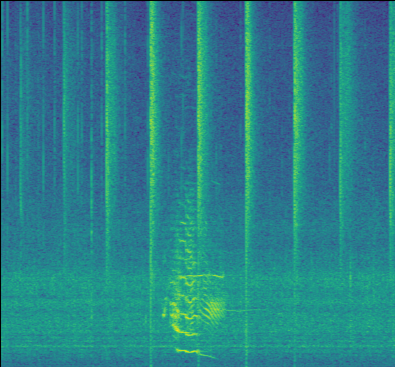

In [58]:
# Crop the spectrograms and save as images 
path = r"C:\Users\kzammit\Documents\PHYS555\orcas_classification\example_crop"
dirs = os.listdir(path)
crop(path, dirs)

# the initial size of the image 

In [59]:
print(orca_dataset.img_labels)

              fn2    label
0      spec-0.png     call
1      spec-1.png     call
2      spec-2.png     call
3      spec-3.png     call
4      spec-4.png     call
..            ...      ...
589  spec-589.png  no_call
590  spec-590.png  no_call
591  spec-591.png  no_call
592  spec-592.png  no_call
593  spec-593.png  no_call

[594 rows x 2 columns]


In [60]:
print('The shape of tensor for 60th image in train dataset: ', orca_dataset[60][0].shape)
print(orca_dataset)

The shape of tensor for 60th image in train dataset:  torch.Size([1, 224, 224])


In [61]:
print(orca_dataset[60][0])

tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0039, 0.0000],
         [0.0000, 0.0000, 0.0039,  ..., 0.0039, 0.0000, 0.0039],
         [0.0000, 0.0039, 0.0039,  ..., 0.0078, 0.0039, 0.0039],
         ...,
         [0.1882, 0.1373, 0.1176,  ..., 0.2863, 0.3608, 0.2745],
         [0.2118, 0.1686, 0.1059,  ..., 0.4078, 0.4667, 0.4627],
         [0.1961, 0.1569, 0.1412,  ..., 0.3922, 0.4392, 0.4784]]])


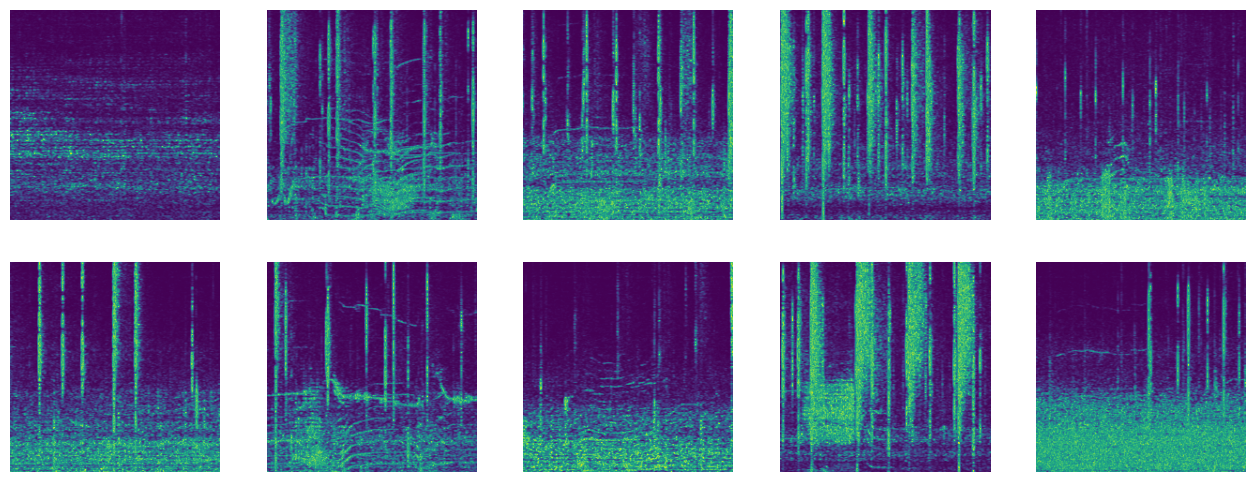

In [62]:
transform = transforms.ToPILImage()
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image, _ = train_loader.dataset.__getitem__(i)
    #print(image.shape)
    image = transform(image)
    plt.imshow(image)
    plt.axis('off');
    #print(image.size)

# Models

In [37]:
def train_test_model(model, train_loader, val_loader, n_epochs, optimizer):
    criterion = nn.MSELoss()
    optimizer = optimizer
    model = model.train()
    train_losses = []
    val_losses = []
    
    for epoch in range(n_epochs):
        train_batch_losses = []
        val_batch_losses = []
        for data in train_loader:
            img, _ = data
            img = img.to(device)
            img = img.reshape(-1, 28*28)
            
            #print(img.shape)
            output = model(img)
            loss = criterion(output, img.data)
            #************************ backward *************************
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_batch_losses.append(loss.item()) 
            
        model = model.eval()
        for data in val_loader:
            output = model(img)
            loss = criterion(output, img.data)
            val_batch_losses.append(loss.item())
            
        train_loss = np.mean(train_batch_losses)
        val_loss = np.mean(val_batch_losses)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
            
        # ***************************** log ***************************
        if epoch % 10 == 0:
            print(f"epoch [{epoch + 1}/{n_epochs}], Train loss:{train_loss: .4f} Valid:{val_loss: .4f}")
            
    ax = plt.figure().gca()
    ax.plot(train_losses)
    ax.plot(val_losses)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'])
    plt.title('Loss monitoring')
    plt.show()
    
    return model.eval()

# Autoencoder

In [38]:
# Creating a DeepAutoencoder class
class DeepAutoencoder(torch.nn.Module):
    def __init__(self):
        super().__init__()        
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(28 * 28, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 10)
        )
          
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(10, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 28 * 28),
            torch.nn.Sigmoid()
        )
  
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

epoch [1/100], Train loss: 0.1582 Valid: 0.2240
epoch [11/100], Train loss: 0.1408 Valid: 0.1075
epoch [21/100], Train loss: 0.0878 Valid: 0.1033
epoch [31/100], Train loss: 0.0615 Valid: 0.0484
epoch [41/100], Train loss: 0.0482 Valid: 0.0325
epoch [51/100], Train loss: 0.0427 Valid: 0.0512
epoch [61/100], Train loss: 0.0410 Valid: 0.0663
epoch [71/100], Train loss: 0.0406 Valid: 0.0482
epoch [81/100], Train loss: 0.0405 Valid: 0.0150
epoch [91/100], Train loss: 0.0404 Valid: 0.0297


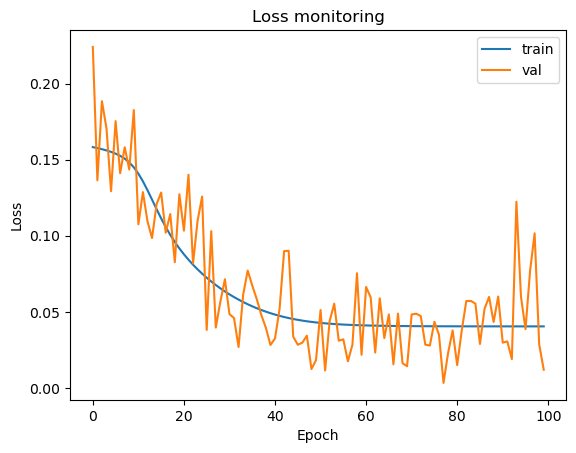

In [51]:
# Instantiating the model and hyperparameters
model = DeepAutoencoder().to(device)
n_epochs = 100
optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)
model = train_test_model(model, train_loader, val_loader, n_epochs, optimizer)

## CNN Autoencoder

In [ ]:
# https://medium.com/thecyphy/train-cnn-model-with-pytorch-21dafb918f48
class CNN_autoencoder2(nn.Module):
    def __init__(self):
        super().__init__() 
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(32,64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        
            nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Flatten(),
            nn.Linear(401408,1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512,40)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(40, 512),
            nn.ReLU(), 
            nn.Linear(512, 1024), 
            nn.ReLU(), 
            nn.Linear(1024, 401408),
            nn.Unflatten(1, torch.Size([128, 56, 56])), 
            
            nn.MaxUnpool2d(2,2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 128, kernel_size=3, stride=1, padding=1), 
            nn.ReLU(), 
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1), 
            nn.ReLU(), 
            
            nn.MaxUnpool2d(2,2), 
            nn.ReLU(), 
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1, padding=1), 
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, padding=1)
        )
           
    def forward(self, x):
        for l in 
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [ ]:
conv_model2 = CNN_autoencoder2().to(device)
num_epochs = 100
optimizer = torch.optim.Adam(conv_model2.parameters(), lr=1e-3)
model = train_test_model2(conv_model2, train_loader, val_loader, num_epochs, optimizer)

# UMAP

In [52]:
#conv_model2 = CNN_autoencoder2().to(device)
#num_epochs = 100
#optimizer = torch.optim.Adam(conv_model2.parameters(), lr=1e-3)
lspaces = []
labels = []
for data in train_loader:
    #img = data[0].reshape(-1, 28*28)
    img = data[0].reshape(-1, 28*28)
    lspace = model.encoder(img.to(device))
    lspacen = lspace.to('cpu')
    lspacen = lspacen.detach().numpy()
    lspaces.append(lspacen)
    if data[1][0]=='call':
        labels.append(1)
    else:
        labels.append(0)

In [53]:
print(len(train_loader))

380


In [54]:
edited = []
for ii in range(0, len(lspaces)):
    edited.append(lspaces[ii][0])

In [55]:
df = pd.DataFrame(edited)

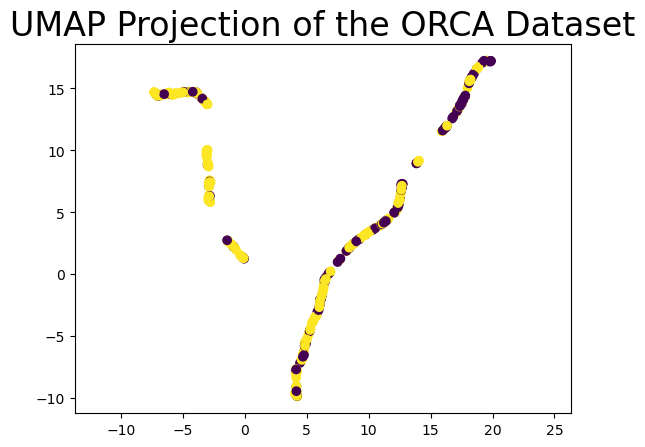

In [56]:
import umap
reducer = umap.UMAP()
embedding = reducer.fit_transform(edited)
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=labels)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP Projection of the ORCA Dataset', fontsize=24);

## Efficient Net Pretrained Encoder, Convolutional Decoder

In [ ]:
# Fake it till u make it bb
# https://towardsdatascience.com/transfer-learning-on-greyscale-images-how-to-fine-tune-pretrained-models-on-black-and-white-9a5150755c7a
def expand_greyscale_image_channels(grey_image):
    grey_image = grey_image.to('cpu')
    grey_image_arr = np.array(grey_image)
    grey_image_arr = np.expand_dims(grey_image_arr, -1)
    grey_image_arr_3_channel = grey_image_arr.repeat(3, axis=-1)
    grey_image_arr_3_channel = torch.from_numpy(grey_image_arr_3_channel)
    grey_image_arr_3_channel = grey_image_arr_3_channel.to(device)
    
    print(grey_image_arr_3_channel.shape)
    grey_image_arr_3_channel = torch.squeeze(grey_image_arr_3_channel)
    print(grey_image_arr_3_channel.shape)
    grey_image_arr_3_channel = grey_image_arr_3_channel.T
    print(grey_image_arr_3_channel.shape)
    grey_image_arr_3_channel = grey_image_arr_3_channel.unsqueeze(0)
    print(grey_image_arr_3_channel.shape)
    return grey_image_arr_3_channel

In [ ]:
class PreT_autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = EfficientNet.from_pretrained('efficientnet-b0', include_top=False)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(1280, 512, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 224, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(224, 1, kernel_size=4, stride=3, padding=1),
            nn.Upsample(1, 1, 2, 2)
        )
        

    def forward(self, x):
        x = expand_greyscale_image_channels(x)
        x = self.encoder.extract_features(x)
        #print(x.shape)
        lspace = x
        for l in self.decoder:
            x = l(x)
            #print(x.shape)
        print(x.shape)
        return x, lspace

In [ ]:
preT_model = PreT_autoencoder().to(device)
num_epochs = 100
#output, lspace = train_model(conv_model, train_loader, num_epochs)
optimizer = torch.optim.Adam(preT_model.parameters(), lr=1e-3)
model, output, lspace = train_test_model(preT_model, train_loader, val_loader, num_epochs, optimizer)

In [ ]:
def train_test_model(model, train_loader, val_loader, n_epochs, optimizer):
    #transform = transforms.ToPILImage()
    criterion = nn.MSELoss()
    optimizer = optimizer
    model = model.train()
    train_losses = []
    val_losses = []
    
    for epoch in range(n_epochs):
        train_batch_losses = []
        val_batch_losses = []
        for data in train_loader:
            img, _ = data
            img    = img.to(device)
            output, lspace = model(img)
            loss = criterion(output, img.data)
            #************************ backward *************************
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_batch_losses.append(loss.item()) 
            
        model = model.eval()
        for data in val_loader:
            output, lspace = model(img)
            loss = criterion(output, img.data)
            val_batch_losses.append(loss.item())
            
        train_loss = np.mean(train_batch_losses)
        val_loss = np.mean(val_batch_losses)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
            
        # ***************************** log ***************************
        if epoch % 100 == 0:
            print(f"epoch [{epoch + 1}/{num_epochs}], Train loss:{train_loss: .4f} Valid:{val_loss: .4f}")
    
    ax = plt.figure().gca()
    ax.plot(train_losses)
    ax.plot(val_losses)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'])
    plt.title('Loss monitoring')
    plt.show()
    
    return model.eval(), output, lspace